In [1]:
from fastai import *
from fastai.text import *
from torch.nn.utils.rnn import pack_sequence, pad_packed_sequence

%reload_ext autoreload
%autoreload 2

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Step 0) Load the data

The data consists of:
- a vocabulary, which is a mapping from an integer id to a character
- train ids - the integer ids encoding the training texts
- val_ids - the integer ids encoding the validation texts



First let's load up the vocabulary

In [2]:
vocab = Vocab(np.load('/data/char-lm-fastai/tmp/itos.pkl'))
vocab.itos[:10]

['xxunk', 'xxpad', ' ', 'e', 'n', 't', 'a', 'o', 'i', 's']

We can use the vocabulary to transform from integer ids to character ids and vice-versa. For example:

In [3]:
text = "make neural networks uncool again"
as_ids = [vocab.stoi[c] for c in text]
print("As ids:", as_ids)
back2txt = ''.join(vocab.itos[i] for i in as_ids)
print("As text:", back2txt)

As ids: [16, 6, 29, 3, 2, 4, 3, 15, 10, 6, 11, 2, 4, 3, 5, 25, 7, 10, 29, 9, 2, 15, 4, 12, 7, 7, 11, 2, 6, 20, 6, 8, 4]
As text: make neural networks uncool again


Next, let's load up the training data and validation data. Each row in the data is a list of integer ids corresponding to the characters in the vocab

In [4]:
train_ids = np.load('/data/char-lm-fastai/tmp/train_ids.npy')
val_ids = np.load('/data/char-lm-fastai/tmp/valid_ids.npy')

In [5]:
display(f"train shape {train_ids.shape}")
display(f"val shape{val_ids.shape}")
print("Example article:")
''.join([vocab.itos[x] for x in train_ids[0]])

'train shape (2063146,)'

'val shape(106529,)'

Example article:


'bosrevlon inc . said it would exit china , where sales of its ... endoftitle cosmetics maker revlon to exit china revlon inc . said it would exit china , where sales of its cosmetics have been falling , and cut more than num_1000_1000000 jobs as part of a restructuring designed to save about $ num_10_100 million a year . revlon , owner of the almay cosmetics brand and sinful colors nail polish , said in a filing that its chinese operations accounted for about num_1_10 percent of total net sales . the company posted net sales of $ num_1_10 billion in num_1000_1000000'

# Step 1) Forward Language Model
The first step to training is to create a data bunch. A databunch is a utility class which takes care of a lot of the boilerplate code, that is often missed or slightly wrong. It takes care of:
- loading up batches in the correct, making sure that the last batch is well-formed
- shuffles the training data
- loads up the data onto a particular device, e.g. the GPU
- applying transforms to the data, see the next section for an example

In [7]:
databunch = TextLMDataBunch.from_ids('/data/char-lm-fastai/tmp', vocab=vocab, 
                                     train_ids= train_ids,
                                     valid_ids = val_ids,
                                     bs = 512)

Now that we have the data, we are ready to define a model and train it. In fastai, you actually create a learner which contains a default model architecture which works great for language models.

In [8]:
vocab_sz = len(vocab.itos)
emb_sz = 100
n_hid = 300

learn = language_model_learner(databunch, emb_sz=emb_sz, nh=n_hid,nl =1 ,drop_mult=0.1, tie_weights=False)
learn.model

SequentialRNN(
  (0): RNNCore(
    (encoder): Embedding(73, 100, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(73, 100, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(100, 100)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=100, out_features=73, bias=True)
    (output_dp): RNNDropout()
  )
)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


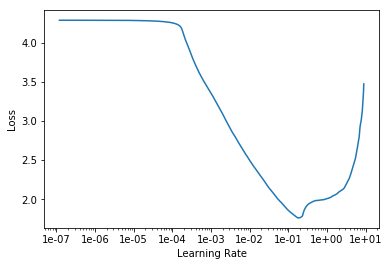

In [9]:
learn.lr_find(start_lr=1e-7, num_it=1000)
learn.recorder.plot()

In [9]:
learn.fit_one_cycle(2, 3e-3)

epoch,train_loss,valid_loss,accuracy
1,1.132079,1.080761,0.684524
2,1.117037,1.057644,0.690922


In [10]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy
1,1.120265,1.058051,0.690958
2,1.111304,1.052797,0.692079
3,1.114191,1.047341,0.693690
4,1.101823,1.043485,0.694640
5,1.106486,1.042297,0.694967


Now, save the model, so we can use it later:

In [11]:
learn.save('fwd_lm')

## Step 2) Backwards Language Model
There is only one difference between a forward and a backward language model - the backwards LM receives and trains on the text in reverse. In fastai, this is achieved by a simple code change - set `backwards=True` when defining the databunch. The library then takes care of reversing the text when making the batches. The rest of the code is the same.

In [6]:
databunch = TextLMDataBunch.from_ids('/data/char-lm-fastai/tmp', vocab=vocab, 
                                     train_ids= train_ids,
                                     valid_ids = val_ids,
                                     bs = 512,
                                     backwards=True) # Set backwards to true

In [7]:
vocab_sz = len(vocab.itos)
emb_sz = 100
n_hid = 300

learn = language_model_learner(databunch, emb_sz=emb_sz, nh=n_hid,nl =1 ,drop_mult=0.1, tie_weights=False)
learn.model

SequentialRNN(
  (0): RNNCore(
    (encoder): Embedding(73, 100, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(73, 100, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(100, 100)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=100, out_features=73, bias=True)
    (output_dp): RNNDropout()
  )
)

In [7]:
learn.fit_one_cycle(2, 3e-3)

epoch,train_loss,valid_loss,accuracy
1,1.147232,1.087566,0.684777
2,1.135380,1.066207,0.689873


In [9]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy
1,1.124710,1.066150,0.690069
2,1.122078,1.062162,0.690919
3,1.131940,1.056962,0.692366
4,1.116715,1.052380,0.693597
5,1.129248,1.051330,0.693889


In [10]:
learn.save('bwd_lm')

# Step 3) Split conjoined words
To identify and split conjoined words, we'll require several conditions to be met:
1. The fwd and bwd language models need to agree that there is a high probability for a space at that position in the text.
2. The unsplit word is not in the provided word vocabulary
3. Both the split words are in the provided word vocabulary
4. Inserting the space leads to a lower average log likelihood for the fwd and backward models

## Step 3.1) Load the vocabs and models

In [4]:
vocab = Vocab(np.load('/data/char-lm-fastai/tmp/itos.pkl'))
word_vocab = set(np.load('/data/suzi/v5/id2w.pkl'))

train_ids = np.zeros((512, 120))
valid_ids = np.zeros((512, 120))
databunch = TextLMDataBunch.from_ids('/data/char-lm-fastai/', vocab=vocab, train_ids=train_ids, valid_ids=valid_ids,
                                     bs=512, backwards=False)

fwd_learn = language_model_learner(databunch, emb_sz=100, nh=300, nl=1, drop_mult=0., tie_weights=False)
fwd_learn.load('/data/char-lm-fastai/tmp/models/fwd_lm')
fwd = fwd_learn.model.cpu()

bwd_learn = language_model_learner(databunch, emb_sz=100, nh=300, nl=1, drop_mult=0., tie_weights=False)
bwd_learn.load('/data/char-lm-fastai/tmp/models/bwd_lm')
bwd = bwd_learn.model.cpu()

In [13]:

def get_space_preds(txts: list, model: SequentialRNN, bwd_model: SequentialRNN, vocab: Vocab, word_vocab: set):
    sequences = [torch.LongTensor(vocab.numericalize(['bos'] + [x for x in txt] + ['bos'])) for txt in txts ]
    fwd_sequences, lens = get_sequences(sequences)
    bwd_sequences, bwd_lens = get_sequences(sequences, reverse=True)

    forward_preds = predict(model, fwd_sequences, lens, vocab)
    backward_preds = predict(bwd_model, bwd_sequences, bwd_lens, vocab)

    dirty = []
    clean = []
    for seq_idx, (seq,seq_len, fwd_pred, bwd_pred) in enumerate(zip(fwd_sequences.t(), lens, forward_preds, backward_preds)):
        orig_txt = [vocab.itos[x] for x in seq[1:seq_len-1] if x != 1]
        fwd_pred = fwd_pred[:-1]
        bwd_pred = bwd_pred[:-1][::-1]
        for i in range(1, len(orig_txt)):
            if orig_txt[i] != ' ' and fwd_pred[i] == ' ' and bwd_pred[i] == ' ':
                concordance_len = 30
                start = max(0, i - concordance_len)
                end = min(len(orig_txt), i + concordance_len)
                r_num_chars = orig_txt[i:end].index(' ') if ' ' in orig_txt[i:end] else 0
                l_num_chars = orig_txt[start:i][::-1].index(' ') if ' ' in orig_txt[start:i] else 0

                wordlen = l_num_chars + r_num_chars

                if wordlen >= 5 and (r_num_chars >= 3 or l_num_chars >= 3):
                    word = ''.join(orig_txt[i-l_num_chars:i+r_num_chars])
                    l_word = ''.join(orig_txt[i-l_num_chars:i])
                    r_word = ''.join(orig_txt[i:i+r_num_chars])

                    if word not in word_vocab and l_word in word_vocab and r_word in word_vocab:
                        with_split = ''.join(orig_txt[:i]) + ' ' + ''.join(orig_txt[i:])
                        orig_score = score_txt(orig_txt, model, vocab) + score_txt(orig_txt[::-1], bwd_model, vocab)
                        split_score = score_txt(with_split, model, vocab) + score_txt(with_split[::-1], bwd_model, vocab)
                        if split_score > orig_score:
                            dirty.append(''.join(orig_txt[start:end]))
                            clean.append(''.join(orig_txt[start:i]) + ' ' + ''.join(orig_txt[i:end]))
    return pd.DataFrame({'dirty': dirty, 'clean': clean})



def score_txt(txt:str, model:nn.Module, vocab: Vocab):
    """
    Computes the average log likelihood of the text under the model
    :param txt: 
    :param model: 
    :param vocab: 
    :return: 
    """
    numericalized = vocab.numericalize(['bos'] + [x for x in txt] + ['bos'])
    model.reset()
    model.eval()
    inp = torch.LongTensor([numericalized]).t()
    preds = F.log_softmax(model(inp)[0], dim=0)
    score = 0.
    for pred, actual in zip(preds, numericalized[1:]):
        score += pred[actual]
    return score / len(txt)

                            
def get_sequences(sequences:list, reverse=False):
    """
    Transforms a list of LongTensors to a padded long tensor
    :param sequences:
    :param reverse:
    :return: a tuple res, lens where res is of shape TxB and lens is the lengths of the items in the batch.
    """
    if reverse:
        sequences = [torch.LongTensor(s.numpy()[::-1].copy()) for s in sequences]
    sorted_sequences = sorted(sequences, key=lambda x: x.size(), reverse=True)
    packed_sequences = pack_sequence(sorted_sequences)
    return pad_packed_sequence(packed_sequences, padding_value=1)

def predict(model: nn.Module, txt:torch.LongTensor, lens:np.array, vocab: Vocab):
    """
    Applies the model and returns the results as a string
    :param model:
    :param txt:
    :param lens:
    :param vocab:
    :return:
    """
    model.eval()
    model.reset()
    forward_preds = model(txt)[0]
    forward_preds = forward_preds.argmax(-1).view(txt.size(0), -1).t()
    res = []
    for preds, length in zip(forward_preds, lens):
        res.append(''.join(vocab.itos[preds[i]] for i in range(length)))
    return res


In [ ]:
pd.set_option('max_colwidth', 300)

bs=2048
for i, chunk in enumerate(pd.read_json('/data/char-lm-fastai/train.jsonl', lines=True, chunksize=bs)):
    if i > 10:
        break
    text = chunk['tokens']
    display(get_space_preds(text, fwd, bwd, vocab, word_vocab))
    

,dirty,clean
0,", num_1000_1000000 . dr . gotto was elected as a class ii d",", num_1000_1000000 . dr . got to was elected as a class ii d"
1,"inance conference endoftitle -vivint 's president , alex dun","inance conference endoftitle - vivint 's president , alex dun"
2,"um_1_10 % in constant currencyfiscal ye ... los angeles , ma","um_1_10 % in constant currency fiscal ye ... los angeles , ma"
3,platinum level for their greenleader hotel program . establi,platinum level for their green leader hotel program . establi
4,tse num_100_1000 index ( indexftse : ukx ) to briefly inch u,tse num_100_1000 index ( index ftse : ukx ) to briefly inch u
5,g a topless barber shop . hairdresser / stripper bree franci,g a topless barber shop . hair dresser / stripper bree franci
6,urray digital content producer- dallas business journal | |,urray digital content producer - dallas business journal | |
7,- num_1_10 ( us abs ) / creditdesk / reports / report_frame.,- num_1_10 ( us abs ) / credit desk / reports / report_frame.
8,for num_1000_1000000 annual pttow ! summitinvite - only memb,for num_1000_1000000 annual pt tow ! summitinvite - only memb
9,_1000000 annual pttow ! summitinvite - only member network w,_1000000 annual pttow ! summit invite - only member network w


,dirty,clean
0,arch and markets : global homewares market num_1000_1000000,arch and markets : global home wares market num_1000_1000000
1,ket endoftitle the global homewares market has several drive,ket endoftitle the global home wares market has several drive
2,the global economy . the homewares market in emerging count,the global economy . the home wares market in emerging count
3,arch and markets : global homewares market num_1000_1000000,arch and markets : global home wares market num_1000_1000000
4,eir offering . the global homewares market has several drive,eir offering . the global home wares market has several drive
5,ation of amantys power insighttm protocol with avago 's 50mb,ation of amantys power insight tm protocol with avago 's 50mb
6,he past financial year include:- customer,he past financial year include :- customer
7,usive agreement to equip unitypoint health with radiotherapy,usive agreement to equip unity point health with radiotherapy
8,zed treatment systems at unitypoint health hospitals across,zed treatment systems at unity point health hospitals across
9,ntered an agreement with unitypoint health to be its exclusi,ntered an agreement with unity point health to be its exclusi


,dirty,clean
0,"been filed against altair nanotechnologies , inc . ( "" altai","been filed against altair nano technologies , inc . ( "" altai"
1,nergy services provider energyexcel llp to further expand it,nergy services provider energy excel llp to further expand it
2,"management business of energyexcel llp , an independent ene","management business of energy excel llp , an independent ene"
3,ecording artists through soundexchange in the united states,ecording artists through sound exchange in the united states
4,hmallow kremetm - filled ghostbuster treats inspired by the,hmallow kremetm - filled ghost buster treats inspired by the
5,me of $ num_10_100 million andnet income per diluted share o,me of $ num_10_100 million and net income per diluted share o
6,nergy services provider energyexcel llp to further expand it,nergy services provider energy excel llp to further expand it
7,"management business of energyexcel llp , an independent ene","management business of energy excel llp , an independent ene"
8,1000 million . it 's operatingincome totaled $ 6.48billion .,1000 million . it 's operating income totaled $ 6.48billion .
9,"rests endoftitle san diego andnew york , july num_10_100 , n","rests endoftitle san diego and new york , july num_10_100 , n"
